In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import regex as re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
data = pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
# Check for null values
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [5]:
data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


We use only the message description to classify it as spam or not. Hence, we drop other columns(they have high no of null values)

In [6]:
# Drop columns with high null values
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
# Rename the other columns
data.rename(columns={'v1':'Class','v2':'Message'},inplace=True)

In [8]:
# Reordering the columns in the dataset
columns = ['Message','Class']
data = data[columns]
data.head(3)

,Message,Class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam


In [9]:
# Check the class distribution
data['Class'].value_counts()

ham     4825
spam     747
Name: Class, dtype: int64

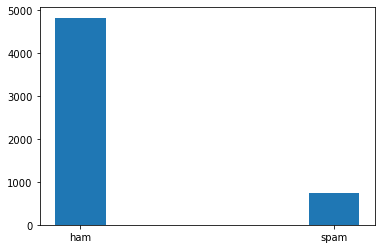

In [10]:
# Plotting the distribution
plt.bar(data['Class'].unique(),data['Class'].value_counts(),width=0.2)
plt.show()

#### Text preprocessing

In [11]:
def process_msg(msg):
    # Convert to lowercase
    msg = msg.lower() 
    # Remove username
    msg = re.sub(r'@[A-Za-z0-9_.]+','',msg)
    # Remove URLs
    msg = re.sub(r'https?://\S+|www\.\S+','',msg)
    # Character normalization
    msg = re.sub(r'([a-zA-Z])\1{2,}','\1',msg)
    # Remove punctuations
    msg = re.sub(r'[^\w\s]','',msg)
    # Remove numbers
    msg = re.sub(r'\d+','',msg)
    # Remove all the stopwords
    english_stop = stopwords.words('english')
    msg = ' '.join([word for word in msg.split() if word not in english_stop])
    # Perform word tokenization
    msg = word_tokenize(msg) # Takes a string, returns it as a list of words
    # Perform lemmatization to find root word
    lemmatizer = WordNetLemmatizer()
    msg = ' '.join([lemmatizer.lemmatize(word) for word in msg])
    return msg

#### Train Test Split

In [12]:
# Splitting the data into target and dependent
x_data = data.iloc[:,0].values
y_data = data.iloc[:,-1].values

In [13]:
# Preprocessing the text messages
x_data = [process_msg(msg) for msg in x_data]
# Representing the message as a list of words
x_data_low = [msg.split() for msg in x_data]

In [14]:
# Splitting the data for training and testing
# We apply stratified splitting of data as we have very few negative class samples(spam)
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.3,stratify=y_data)

In [15]:
# Representing the message as a list of words
x_train_low = [msg.split() for msg in x_train]
x_test_low = [msg.split() for msg in x_test]

#### Creating a vocabulary

In [16]:
vocab = []
for msg in x_data_low:
    for word in msg:
        if word not in vocab:
            vocab.append(word)

In [17]:
print("Size of vocabulary: ",len(vocab))

Size of vocabulary:  7842


#### Creating feature vectors using TF-IDF

In [18]:
# Creating TF-IDF vectors
tf_idf = TfidfVectorizer()
train_vector = tf_idf.fit_transform(x_train)
test_vector = tf_idf.transform(x_test)

<b>Model Training using TF-IDF vector representations</b>

#### Logistic Regression

In [19]:
log_reg = LogisticRegression()
log_reg.fit(train_vector,y_train)

LogisticRegression()

In [20]:
log_pred = log_reg.predict(train_vector)
print("Accuracy score: ",round(accuracy_score(y_train,log_pred),2))
print("\nClassification Report:\n",classification_report(y_train,log_pred))

Accuracy score:  0.96

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3377
        spam       0.99      0.75      0.85       523

    accuracy                           0.96      3900
   macro avg       0.97      0.87      0.92      3900
weighted avg       0.97      0.96      0.96      3900



#### Naive Bayes

In [21]:
nb = GaussianNB()
nb.fit(train_vector.todense(),y_train)

GaussianNB()

In [22]:
nb_pred = nb.predict(train_vector.todense())
print("Accuracy score: ",round(accuracy_score(y_train,nb_pred),2))
print("\nClassification Report:\n",classification_report(y_train,nb_pred))

Accuracy score:  0.95

Classification Report:
               precision    recall  f1-score   support

         ham       1.00      0.94      0.97      3377
        spam       0.72      1.00      0.84       523

    accuracy                           0.95      3900
   macro avg       0.86      0.97      0.90      3900
weighted avg       0.96      0.95      0.95      3900



#### Support Vector Classifier

In [23]:
svc = SVC()
svc.fit(train_vector,y_train)

SVC()

In [24]:
svc_pred = svc.predict(train_vector)
print("Accuracy score: ",round(accuracy_score(y_train,svc_pred),2))
print("\nClassification Report:\n",classification_report(y_train,log_pred))

Accuracy score:  1.0

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3377
        spam       0.99      0.75      0.85       523

    accuracy                           0.96      3900
   macro avg       0.97      0.87      0.92      3900
weighted avg       0.97      0.96      0.96      3900



In [25]:
# Performance on train data
tfidf_result = {'Model':['Logistic Regression','Naive Bayes','SVC'],'Accuracy':['96%','95%','100%']}
result_df = pd.DataFrame(tfidf_result)
result_df

,Model,Accuracy
0,Logistic Regression,96%
1,Naive Bayes,95%
2,SVC,100%


#### Creating word embeddings using Word2Vec

In [26]:
# Creating word embeddings using Word2Vec
model = Word2Vec(sentences = x_train_low, vector_size = 100, workers = 5, window = 3, epochs = 5)

In [27]:
# List of words in the model's vocab 
words_in_model = model.wv.index_to_key

In [28]:
def word_in_vocab(sentence):
    words = 0
    total_words = len(sentence)
    for word in sentence:
        if word in words_in_model:
            words += 1
    if words != total_words:
    # If all words are not present in vocab of the model, we create a numpy array of zeros of same dimension as the word vector
        return False 
    else:
        return True

In [29]:
train_wv = [model.wv[sentence].sum(axis = 0) if len(sentence) != 0 and word_in_vocab(sentence) else np.zeros((100)) for sentence in x_train_low]
test_wv = [model.wv[sentence].sum(axis = 0) if len(sentence) != 0 and word_in_vocab(sentence) else np.zeros((100)) for sentence in x_test_low]

<b>Model Training using Word2Vec word embeddings</b>

#### Logistic Regression

In [30]:
log_r = LogisticRegression()
log_r.fit(train_wv,y_train)

LogisticRegression()

In [31]:
log_p = log_r.predict(train_wv)
print("Accuracy score: ",round(accuracy_score(y_train,log_p),2))
print("\nClassification Report:\n",classification_report(y_train,log_p))

Accuracy score:  0.88

Classification Report:
               precision    recall  f1-score   support

         ham       0.88      1.00      0.93      3377
        spam       1.00      0.09      0.16       523

    accuracy                           0.88      3900
   macro avg       0.94      0.54      0.55      3900
weighted avg       0.89      0.88      0.83      3900



#### Naive Bayes

In [32]:
nb = GaussianNB()
nb.fit(train_wv,y_train)

GaussianNB()

In [33]:
nb_p = nb.predict(train_wv)
print("Accuracy score: ",round(accuracy_score(y_train,nb_p),2))
print("\nClassification Report:\n",classification_report(y_train,nb_p))

Accuracy score:  0.79

Classification Report:
               precision    recall  f1-score   support

         ham       0.88      0.89      0.88      3377
        spam       0.20      0.18      0.19       523

    accuracy                           0.79      3900
   macro avg       0.54      0.53      0.54      3900
weighted avg       0.78      0.79      0.79      3900



#### Support Vector Classifier

In [34]:
svc = SVC()
svc.fit(train_wv,y_train)

SVC()

In [35]:
svc_p = svc.predict(train_wv)

print("Accuracy score: ",round(accuracy_score(y_train,svc_p),2))

print("\nClassification Report:\n",classification_report(y_train,svc_p))

Accuracy score:  0.87

Classification Report:
               precision    recall  f1-score   support

         ham       0.88      0.99      0.93      3377
        spam       0.75      0.10      0.17       523

    accuracy                           0.87      3900
   macro avg       0.81      0.55      0.55      3900
weighted avg       0.86      0.87      0.83      3900



In [36]:
# Performance on train data

w2v_result = {'Model':['Logistic Regression','Naive Bayes','SVC'],'Accuracy':['88%','79%','87%']}

result_df = pd.DataFrame(w2v_result)

result_df

,Model,Accuracy
0,Logistic Regression,88%
1,Naive Bayes,79%
2,SVC,87%


In [37]:
test_pred = log_reg.predict(test_vector) 

In [38]:
print("Accuracy score: ",round(accuracy_score(test_pred,y_test),2))

print("\nClassification Report:\n",classification_report(y_test,test_pred))

Accuracy score:  0.96

Classification Report:
               precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1448
        spam       0.97      0.69      0.81       224

    accuracy                           0.96      1672
   macro avg       0.96      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672

